In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [20]:
df = pd.read_csv('NVDA.csv')
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,Date,Adj Close,Close,High,Low,Open,Volume
0,28/11/2022,15.812541,15.827000,16.357000,15.725,16.025999,303741000
1,29/11/2022,15.624713,15.639000,15.932000,15.520,15.827000,298384000
2,30/11/2022,16.911863,16.923000,16.930000,15.597,15.697000,565298000
3,01/12/2022,17.123726,17.135000,17.264999,16.635,16.999001,470977000
4,02/12/2022,16.864895,16.875999,16.933001,16.445,16.659000,371389000


In [21]:
def handle_missing_data(data):
    """
    Check for missing data
    """
    print("Missing Data Summary:\n", df.isnull().sum())
    return data.fillna(df.mean(numeric_only=True), inplace=True)

data_cleaned = handle_missing_data(df)

Missing Data Summary:
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [22]:
# Create target variable (1 if price went up, 0 if down)
df['Target'] = (df['Adj Close'].shift(-1) > df['Adj Close']).astype(int)

# Create technical indicators
df['Returns'] = df['Adj Close'].pct_change()
df['Volume_Change'] = df['Volume'].pct_change()
df['High_Low_Range'] = df['High'] - df['Low']
df['Open_Close_Range'] = df['Close'] - df['Open']

# Create moving averages
df['MA5'] = df['Adj Close'].rolling(window=5).mean()
df['MA20'] = df['Adj Close'].rolling(window=20).mean()

# Create RSI
delta = df['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values
df = df.dropna()

# Select features for model
features = ['Returns', 'Volume_Change', 'High_Low_Range',
           'Open_Close_Range', 'MA5', 'MA20', 'RSI']

print("\nFeatures created:")
for feature in features:
    print(f"- {feature}")


Features created:
- Returns
- Volume_Change
- High_Low_Range
- Open_Close_Range
- MA5
- MA20
- RSI



Basic Statistics:


,Returns,Volume_Change,High_Low_Range,Open_Close_Range,MA5,MA20,RSI,Target
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.005041,0.037786,2.601826,-0.005339,68.141253,66.166864,59.572489,0.566116
std,0.032293,0.301342,2.193877,2.066884,39.531393,38.650718,16.487282,0.496122
min,-0.100046,-0.672406,0.378000,-9.020004,14.328366,15.460720,8.187870,0.000000
25%,-0.014464,-0.157882,1.012001,-0.621502,41.237969,39.008301,47.224812,0.000000
50%,0.004303,-0.015863,1.764502,0.095000,48.851154,47.781315,61.427275,1.000000
75%,0.022595,0.180440,3.547504,0.828501,106.303406,101.884240,71.353040,1.000000
max,0.243696,1.228817,13.350006,8.389999,147.266000,142.878999,96.994857,1.000000


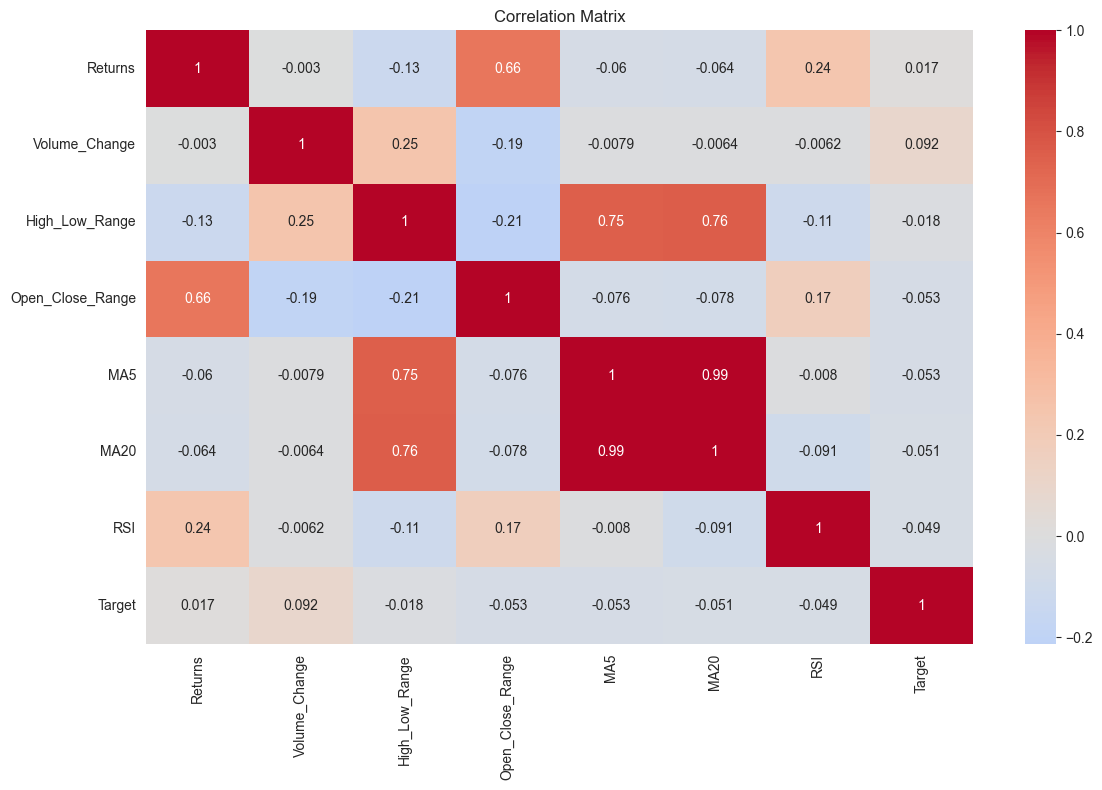

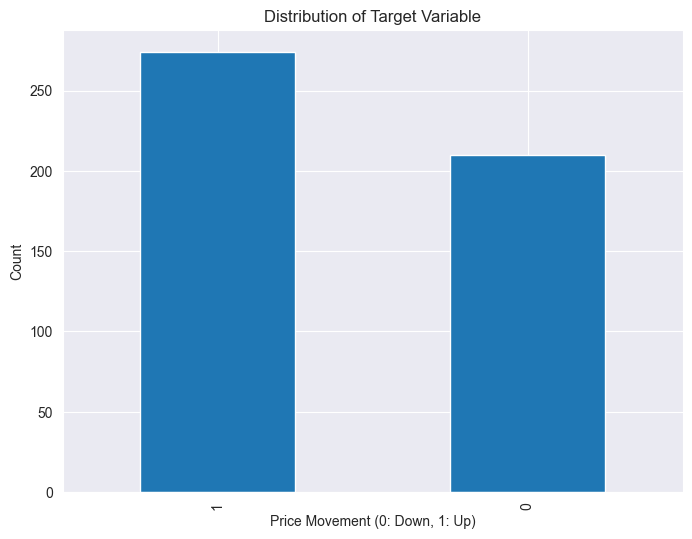

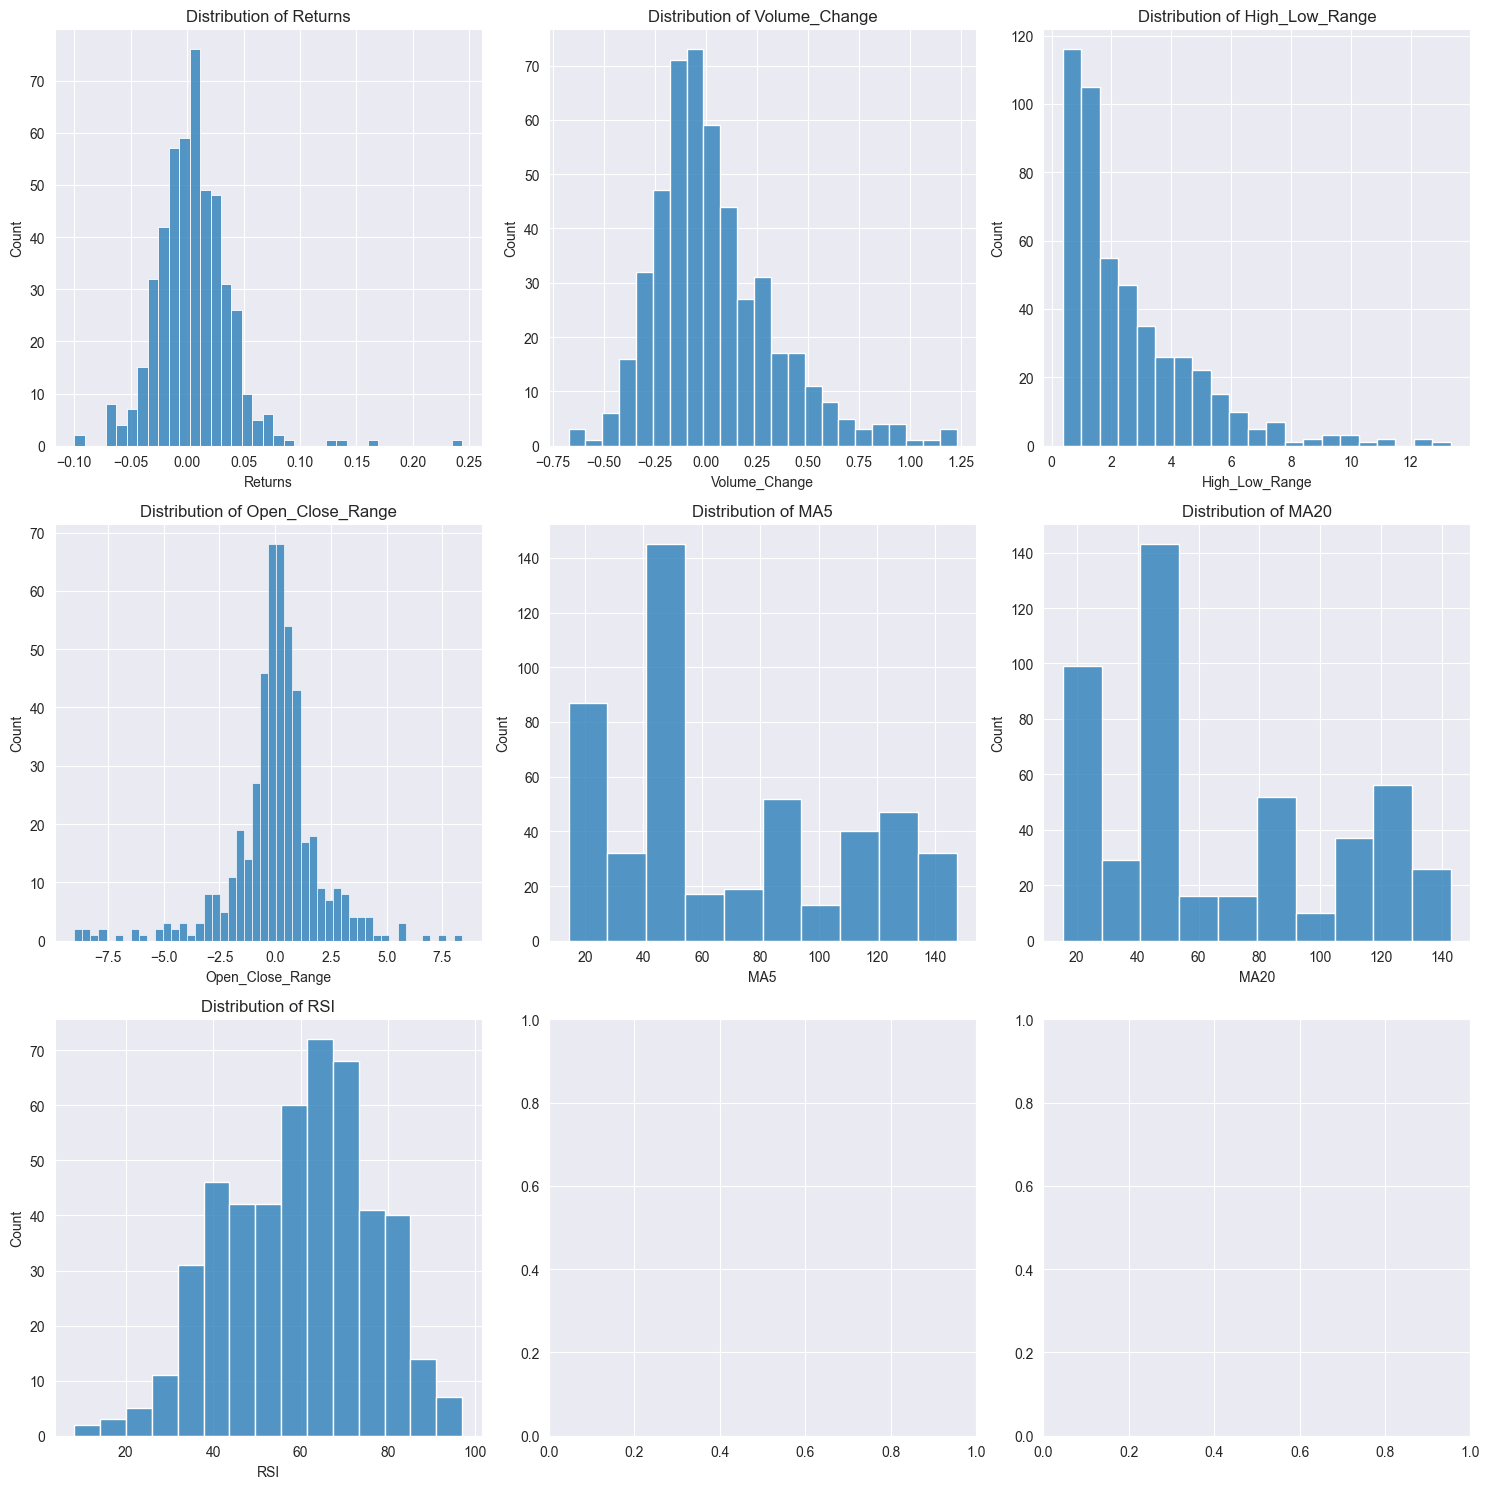

In [23]:
# Basic statistics
print("\nBasic Statistics:")
display(df[features + ['Target']].describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(8, 6))
df['Target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Price Movement (0: Down, 1: Up)')
plt.ylabel('Count')
plt.show()

# Feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(features):
    if idx < len(axes):
        sns.histplot(data=df, x=col, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [24]:
# Cell 5: Data Split
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (387, 7)
Testing set shape: (97, 7)


In [ ]:
# Cell 6: Train Models
# Gini Model
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

# Entropy Model
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)

In [26]:
# Cell 7: Model Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_pred, y_pred_proba

# Evaluate both models
y_pred_gini, y_pred_proba_gini = evaluate_model(dt_gini, X_test, y_test, "Gini Model")
y_pred_entropy, y_pred_proba_entropy = evaluate_model(dt_entropy, X_test, y_test, "Entropy Model")


Gini Model Results:
Accuracy: 0.5464
Precision: 0.6818
Recall: 0.5000
F1 Score: 0.5769

Entropy Model Results:
Accuracy: 0.5773
Precision: 0.7021
Recall: 0.5500
F1 Score: 0.6168


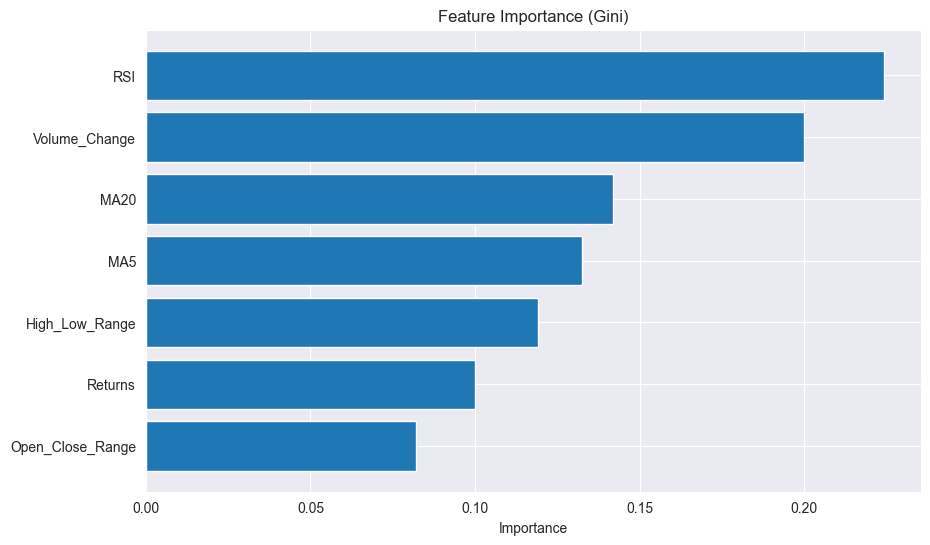

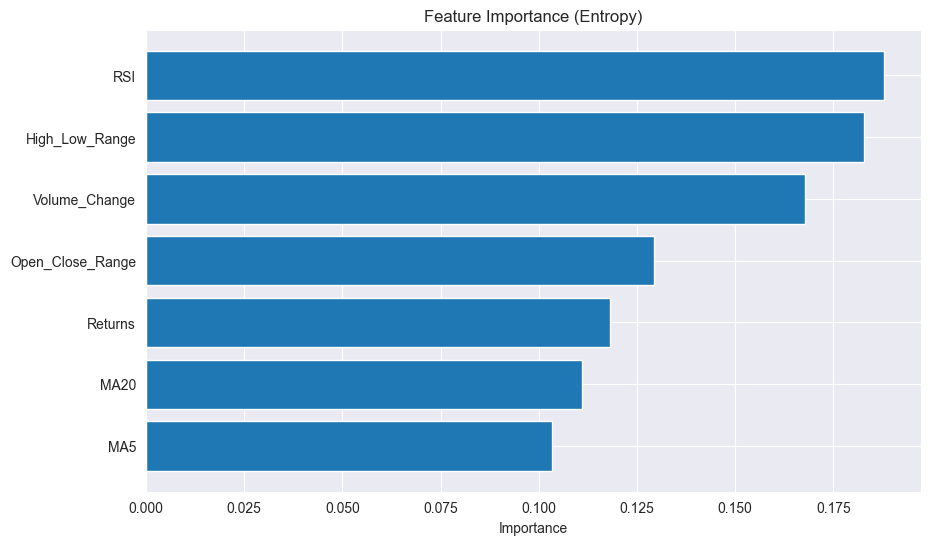

In [27]:
# Cell 8: Feature Importance
def plot_feature_importance(model, features, model_name):
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importances['feature'], importances['importance'])
    plt.title(f'Feature Importance ({model_name})')
    plt.xlabel('Importance')
    plt.show()

plot_feature_importance(dt_gini, features, "Gini")
plot_feature_importance(dt_entropy, features, "Entropy")

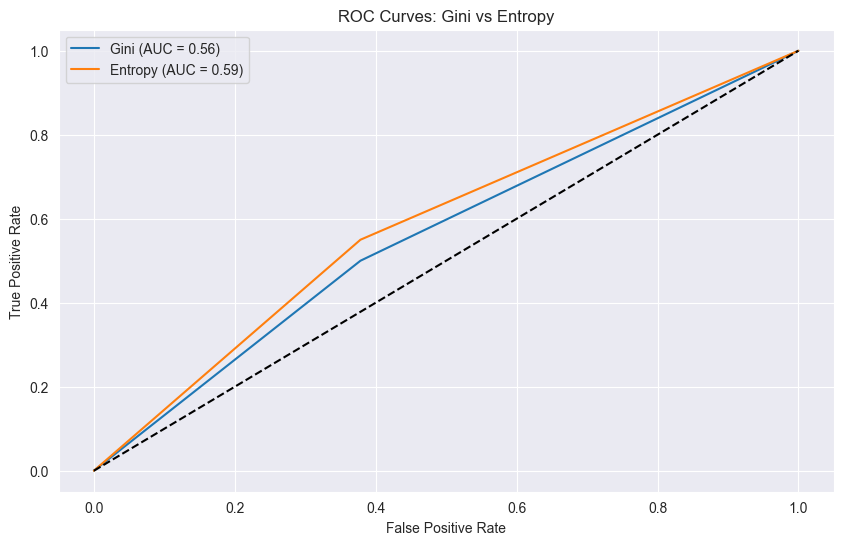

In [28]:
# Cell 9: ROC Curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Gini vs Entropy')
    plt.legend()
    plt.show()

plot_roc_curves({'Gini': dt_gini, 'Entropy': dt_entropy}, X_test, y_test)

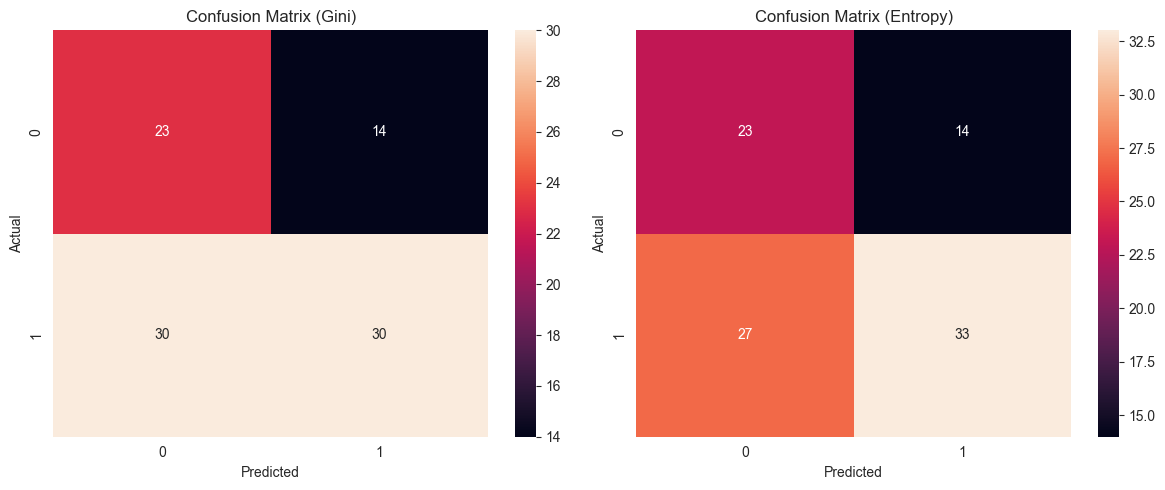

In [29]:
# Cell 10: Confusion Matrices
def plot_confusion_matrices(y_test, y_pred_gini, y_pred_entropy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(confusion_matrix(y_test, y_pred_gini), annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix (Gini)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    sns.heatmap(confusion_matrix(y_test, y_pred_entropy), annot=True, fmt='d', ax=ax2)
    ax2.set_title('Confusion Matrix (Entropy)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test, y_pred_gini, y_pred_entropy)

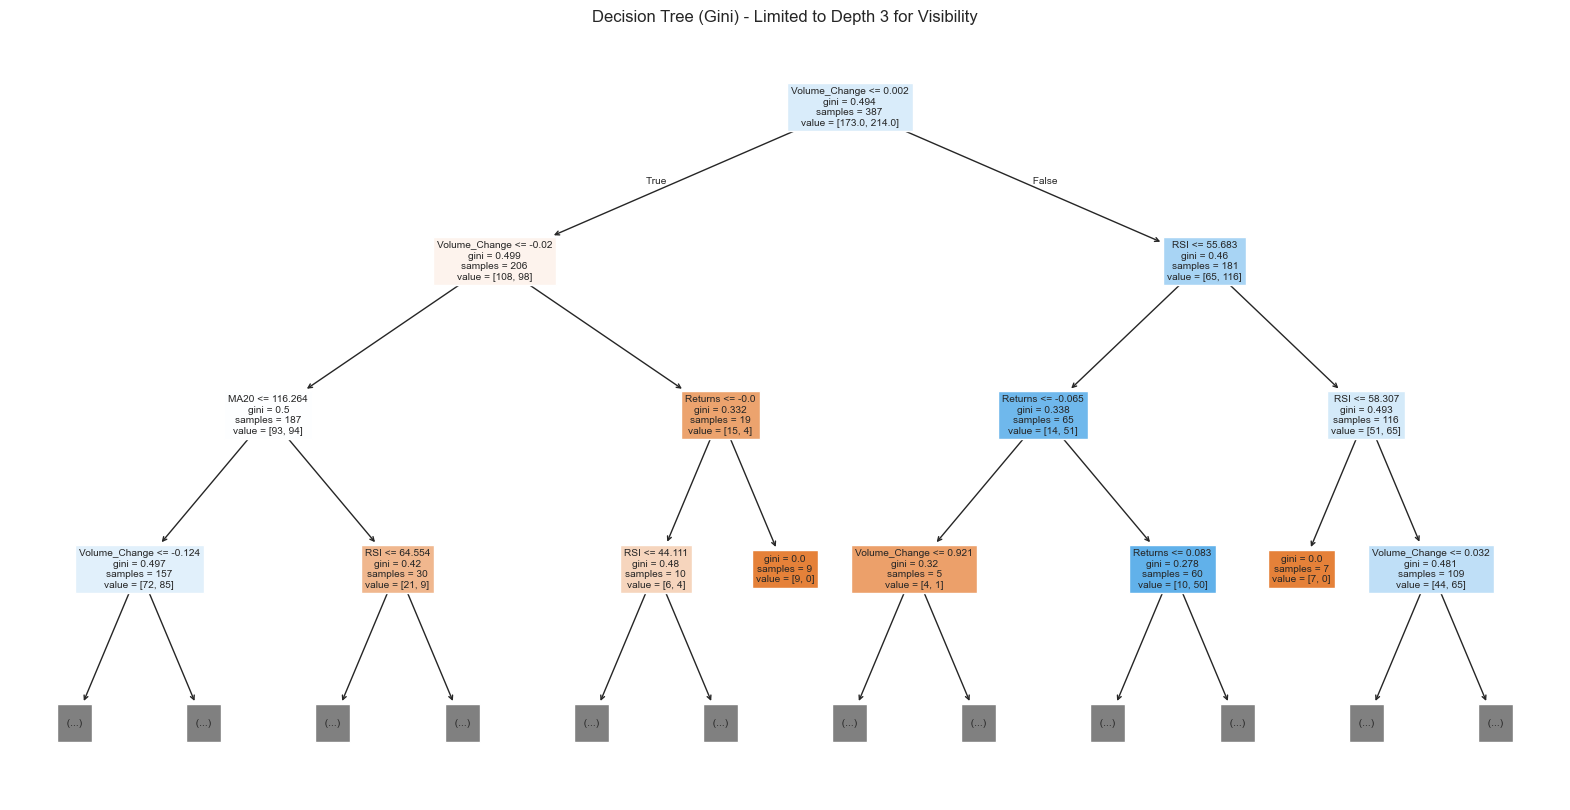

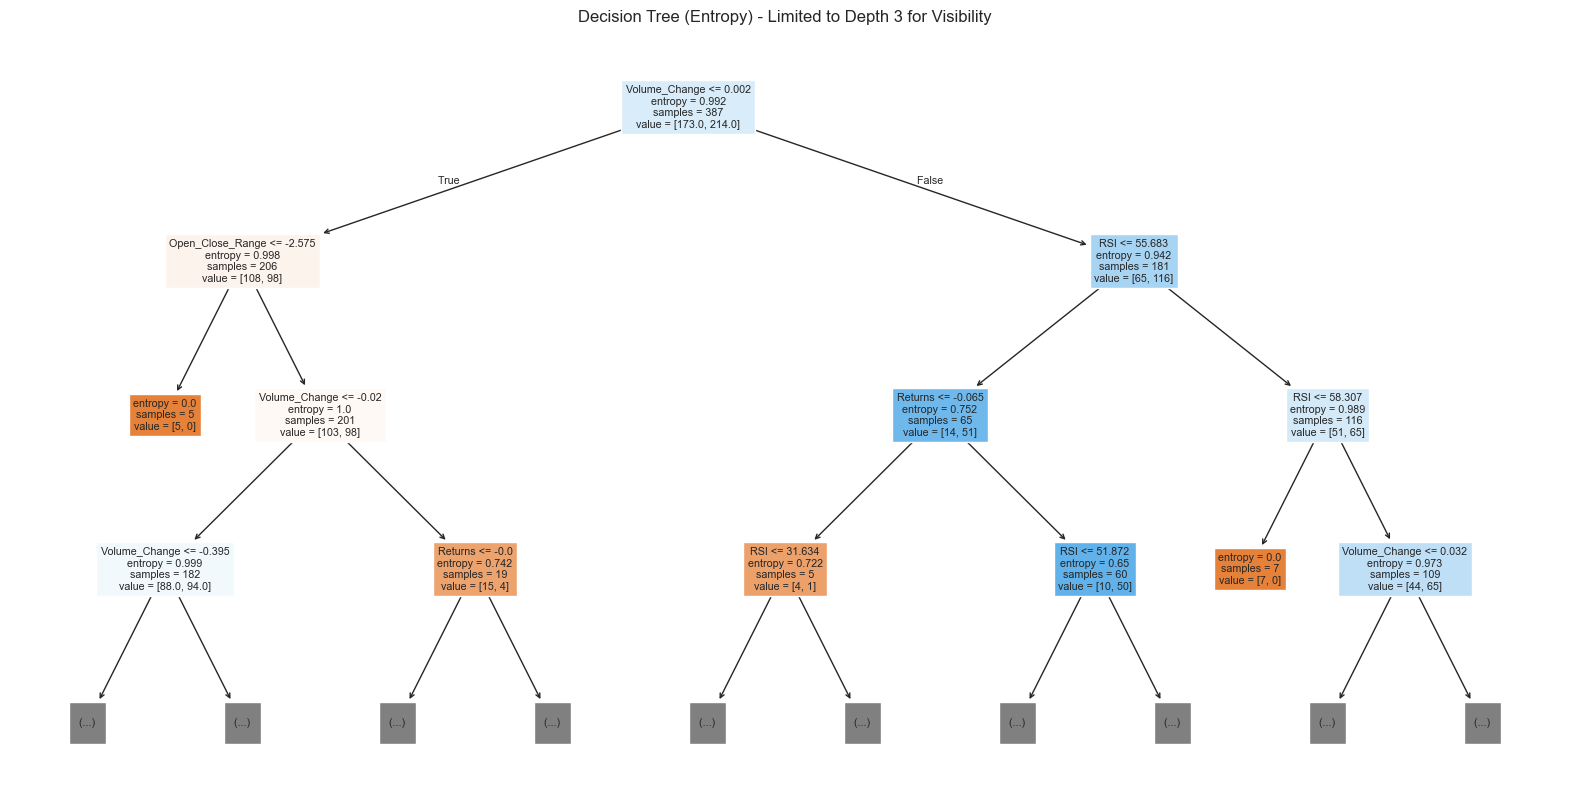

In [30]:
# Cell 11: Visualize Decision Trees
plt.figure(figsize=(20, 10))
plot_tree(dt_gini, feature_names=features, filled=True, max_depth=3)
plt.title('Decision Tree (Gini) - Limited to Depth 3 for Visibility')
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(dt_entropy, feature_names=features, filled=True, max_depth=3)
plt.title('Decision Tree (Entropy) - Limited to Depth 3 for Visibility')
plt.show()

In [2]:
print("\nFeature Importance Comparison:")
display(comparison)

print("\nKey Findings:")
print("1. Model Performance:")
print("   - Compare accuracy, precision, recall, and F1 scores above")
print("2. Feature Importance:")
print(f"   - Most important feature (Gini): {comparison.iloc[0]['feature']}")
print(f"   - Most important feature (Entropy): {comparison.iloc[0]['feature']}")
print("3. ROC Analysis:")
print("   - Compare AUC scores from ROC curves above")
print("4. Model Complexity:")
print(f"   - Gini tree depth: {dt_gini.get_depth()}")
print(f"   - Entropy tree depth: {dt_entropy.get_depth()}")


Feature Importance Comparison:


[]


Key Findings:
1. Model Performance:
   - Compare accuracy, precision, recall, and F1 scores above
2. Feature Importance:


AttributeError: 'list' object has no attribute 'iloc'